In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#pip install ISLP

In [16]:
#import necessary modules
import os
import numpy as np
import csv
from tabulate import tabulate
import sys
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ISLP import confusion_table
from functools import partial
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

from statsmodels.api import GLM
from ISLP.models import ModelSpec as MS
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## regular knn

In [6]:
df = pd.read_csv('/content/drive/My Drive/415/datasci 415/full_dataset.csv')
df['winner_2020_encoded'] = df['winner_2020'].apply(lambda x: 1 if x == 'Democrat' else 0)
df['State'] = df['State'].astype('category')

In [7]:
#all relevant predictors, REMOVE state:
allvars2 = df.columns.drop(['total_votes_2020', 'county_names_with_casing','prop_favored_dem_2020', 'winner_2020', 'County', 'winner_2020_encoded', 'State'])
y = df['winner_2020_encoded']
X = df[allvars2]
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# Create the KNN model
knn = KNeighborsClassifier()

# Define the range of k values to search over
param_grid = {'n_neighbors': np.arange(10, 30)}  # From 1 to 20 neighbors

# Use GridSearchCV to search over the hyperparameter grid with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameter and best score
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best k: {best_k}")
print(f"Best cross-validated accuracy: {best_score}")

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ea39b755510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory


Best k: 22
Best cross-validated accuracy: 0.8644320919913161


In [9]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,505,83
1,11,29


In [10]:
#try standardizing -- looks a lot better
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled, X_test_scaled = [np.asarray(X) for X in [X_train_scaled, X_test_scaled]]
knn1.fit(X_train_scaled, y_train)
y_pred = knn1.predict(X_test_scaled)
confusion_table(y_pred, y_test)

Truth,0,1
Predicted,,
0,509,30
1,7,82


In [22]:
#final model -- standardized, limited predictors, CV for k
scaler = StandardScaler()
y = df['winner_2020_encoded']
X = df[['prop_favored_dem_2012', 'prop_favored_dem_2016']] #predictors from simple classification selection
for col in X.select_dtypes(include=[bool]).columns:
    X[col] = X[col].astype(int)

X = scaler.fit_transform(X) #X is now standardized

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(10, 30)}  # CV neighbors
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Best k: {best_k}") #17
print(f"Best cross-validated accuracy: {best_score}")

Best k: 15
Best cross-validated accuracy: 0.9828550071172397


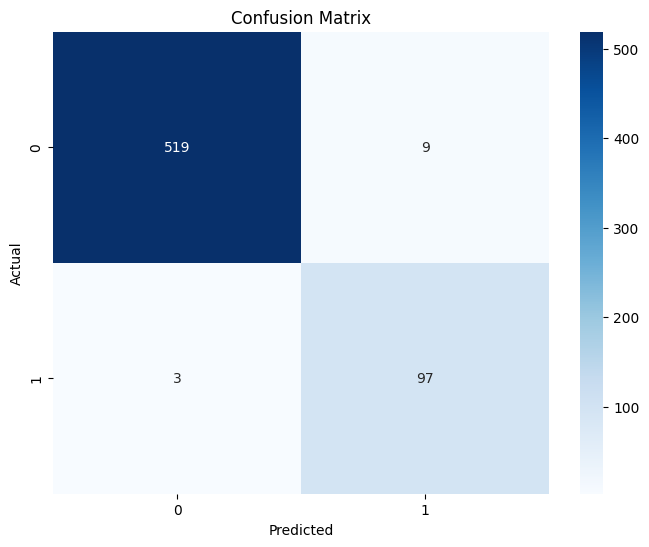

In [23]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
#confusion_table(y_pred, y_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#model looks really good

## location data

In [ ]:
uscounties = pd.read_csv('/content/drive/My Drive/415/datasci 415/uscounties.csv')
df_full = pd.merge(df, uscounties, on='county_fips', how='left')
len(df_full)

In [ ]:
df1 = df_full[df_full.isna().any(axis=1)] #missing data rows
df1 = df1[['County', 'State', 'county_names_with_casing', 'county_fips', 'county', 'county_ascii', 'county_full', 'state_id']]
df1

In [ ]:
#missing alaska rows can be found -> county_names_with_casing = county_full
df1_ak = df1[df1['State'] == 'AK']
df1_ak = df1_ak[['State', 'county_names_with_casing']]
df1_ak = pd.merge(df1_ak, df, on=['county_names_with_casing', 'State'])
df1_ak = pd.merge(df1_ak, uscounties, left_on=['county_names_with_casing', 'State'], right_on=['county_full', 'state_id'], how='left')
df1_ak

In [ ]:
df_full = df_full[(df_full['State'] != 'AK') | (df_full['county'].notna())]
print(len(df_full))
df_full = pd.concat([df_full, df1_ak])
print(len(df_full))
df_full.drop(['county_fips_x', 'county_fips_y'], axis=1, inplace=True)

In [ ]:
#missing CT rows?
#df1[df1['State'] == 'CT'] -- regular df

ct = uscounties[uscounties['state_id'] == 'CT'] #need to manually match them with loc df

In [ ]:
#change 'county' column to what i want to match with
ct_counties = ['Tolland County', 'Fairfield County', 'New Haven County', 'Hartford County', 'NA',
               'New London County', 'Middlesex County', 'Litchfield County', 'Windham County']
ct.loc[:, 'county'] = ct_counties
ct #nice

In [ ]:
#put ct in big df
ct = pd.merge(df, ct, left_on=['county_names_with_casing', 'State'], right_on=['county', 'state_id'], how='right')
ct = ct.dropna()
ct.drop(['county_fips_y'], axis=1, inplace=True)
ct.rename({'county_fips_x': 'county_fips'}, axis=1, inplace=True)
ct

In [ ]:
df_full = df_full[(df_full['State'] != 'CT')]
print(len(df_full))
df_full = pd.concat([df_full, ct])
print(len(df_full))

In [ ]:
na_per_column = df_full.isna().any()
#print(na_per_column) #sanity check

In [ ]:
#df_full.to_csv('/content/drive/My Drive/415/datasci 415/full_dataset_with_location.csv', index=False)

## using location

In [ ]:
df = df_full

In [ ]:
df.columns

In [ ]:
y = df['winner_2020_encoded']
X = df[['lat', 'lng']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(10, 30)}  # From 1 to 20 neighbors
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best k: {best_k}")
print(f"Best cross-validated accuracy: {best_score}")

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test)
#using only location does about as well as a regular model with all predictors

In [ ]:
y = df['winner_2020_encoded']
X = df[['prop_favored_dem_2012', 'prop_favored_dem_2016']]  #its just always best with these two and nothing else

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
knn1 = KNeighborsClassifier(n_neighbors=best_k)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)
confusion_table(y_pred, y_test)